<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250409%5D%20FedAvg-DL%20with%20MLP-LSTM%20model%20on%20WSN-BFSF%20with%20early%20stopped_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL // with clean MLP-LSTM model 4 classes on WSN-BFSF**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("dataset.csv") #WSN-BFSF 4 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,TTL,Hop_Count,Broadcast_ID,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,Class
0,1,0.100000,79,79,600.000000,5,0,79.255,1.255,48,30,1,1,100,0,79,4,0
1,2,0.100963,78,78,599.979723,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
2,2,0.100963,76,76,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
3,2,0.100964,75,75,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
4,2,0.100964,118,118,599.979722,5,800,79.255,1.255,48,30,1,1,100,0,79,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312101,4,656.526536,140,140,465.332078,5,800,140.255,1.255,48,30,1,31,100,16,140,68,1
312102,4,657.209643,140,140,465.191806,5,800,140.255,1.255,48,30,1,33,100,16,140,72,1
312103,4,657.891729,140,140,465.051737,5,800,140.255,1.255,48,30,1,35,100,16,140,76,1
312104,4,658.574656,140,140,464.911501,5,800,140.255,1.255,48,30,1,37,100,16,140,80,1


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [262851  11766   7645  29844]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [262851 262851 262851 262851]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, InputLayer
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input data for LSTM compatibility
# Assuming the input features need to be reshaped into a 3D array: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the hybrid MLP + LSTM model with regularization
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=input_shape))

    # LSTM Layer
    model.add(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # MLP Layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Adjusted for LSTM input format
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 270s 10ms/step - accuracy: 0.7800 - loss: 0.6196 - val_accuracy: 0.9028 - val_loss: 0.2969
Epoch 2/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 248s 9ms/step - accuracy: 0.9065 - loss: 0.2944 - val_accuracy: 0.9331 - val_loss: 0.2196
Epoch 3/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 246s 9ms/step - accuracy: 0.9238 - loss: 0.2506 - val_accuracy: 0.9450 - val_loss: 0.1950
Epoch 4/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 262s 10ms/step - accuracy: 0.9345 - loss: 0.2239 - val_accuracy: 0.9287 - val_loss: 0.2349
Epoch 5/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 256s 10ms/step - accuracy: 0.9435 - loss: 0.1998 - val_accuracy: 0.9534 - val_loss: 0.1677
Epoch 6/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 250s 10ms/step - accuracy: 0.9501 - loss: 0.1849 - val_accuracy: 0.9586 - val_loss: 0.1602
Epoch 7/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 249s 9ms/step - accuracy: 0.9525 - loss: 0.1781 - val_accuracy: 0.9297 - val_loss: 0.4900
Epoch 8/50
26286/26286 ━━━━━━━━━━━━━━━━━━━━ 245s 9ms/step 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9851817330
Precision: 0.9852619285
Recall: 0.9851817330
F1-Score: 0.9851939411


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
Accuracy: 0.9851817330
Precision: 0.9852619285
Recall: 0.9851817330
F1-Score: 0.9851939411


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[51633   652   285     0]
 [  931 51573    15    51]
 [  122    70 52378     0]
 [    0   676   314 51581]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.98217615 0.98103481 0.99634773 0.98116832]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-15-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9994466221
Class 1: 0.9989670789
Class 2: 0.9996473278
Class 3: 0.9997057370

Macro-average AUC: 0.9994416914


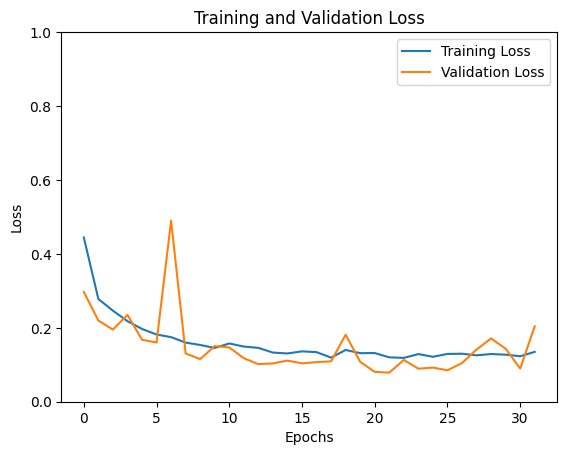

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

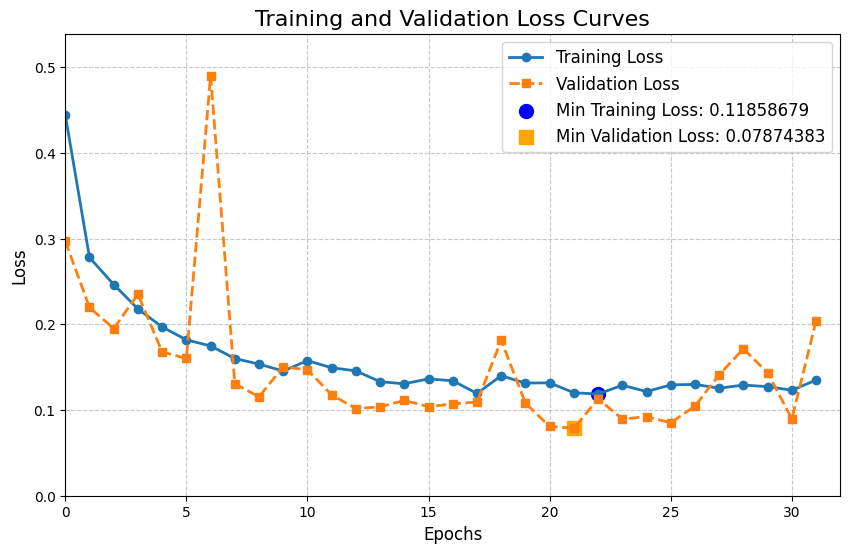

In [ ]:
# prompt: Plot Training and Validation Loss in the way more mathmatically

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...


# Plot Training and Validation Loss with mathematical details
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', linestyle='--', linewidth=2)

# Add mathematical details to the plot
min_training_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
min_training_loss_epoch = history.history['loss'].index(min_training_loss)
min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)

plt.scatter(min_training_loss_epoch, min_training_loss, color='blue', marker='o', s=100, label=f'Min Training Loss: {min_training_loss:.8f}')
plt.scatter(min_val_loss_epoch, min_val_loss, color='orange', marker='s', s=100, label=f'Min Validation Loss: {min_val_loss:.8f}')


plt.title('Training and Validation Loss Curves', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.legend(fontsize=12)

plt.xlim(0, len(history.history['loss'])) # Ensure x-axis covers all epochs
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss']))*1.1) #adjust y axis limit

plt.show()


<ipython-input-18-e1c5c7879700>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


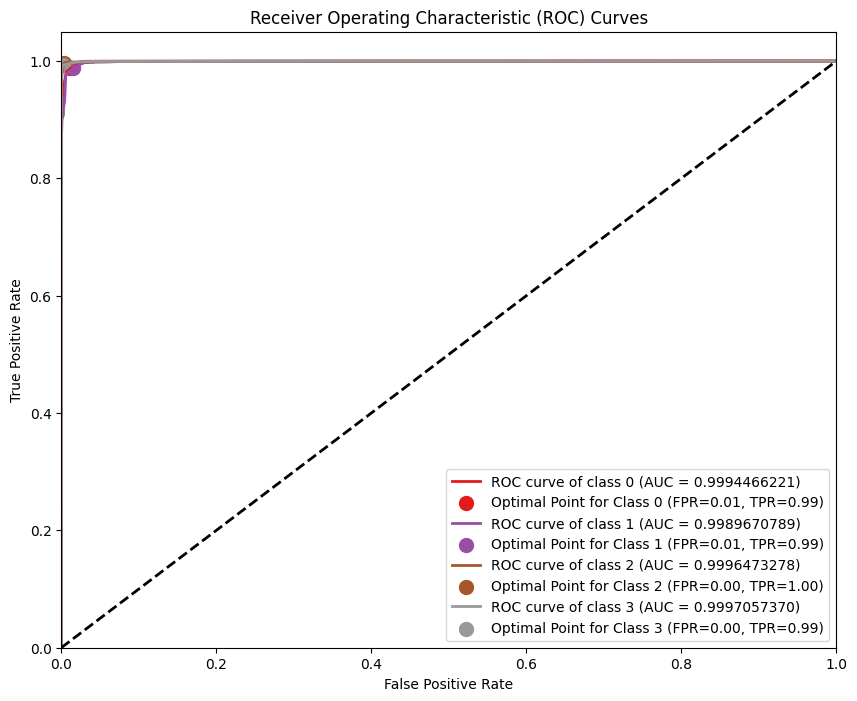


AUC Scores for each class:
Class 0: 0.9994466221
Class 1: 0.9989670789
Class 2: 0.9996473278
Class 3: 0.9997057370

Macro-average AUC: 0.9994416914


In [ ]:
# prompt: Plot ROC curves and AUC for each class in the way more mathamaticall and show label to point out an important value

from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.10f})')
    # Find the point closest to (0,1)
    distances = np.sqrt(fpr[i]**2 + (1-tpr[i])**2)
    min_index = np.argmin(distances)
    plt.scatter(fpr[i][min_index], tpr[i][min_index], marker='o', s=100, color=color,
                label=f'Optimal Point for Class {i} (FPR={fpr[i][min_index]:.2f}, TPR={tpr[i][min_index]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show() # Display the plot


# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


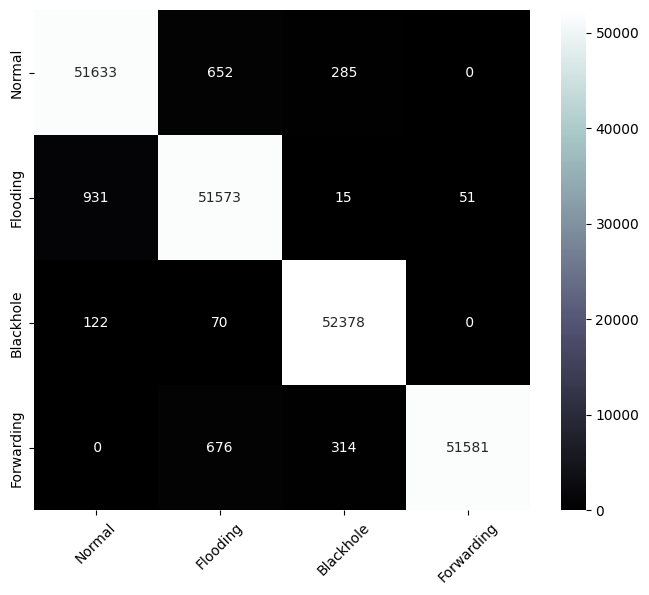

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(4), labels=['Normal','Flooding','Blackhole','Forwarding'], rotation=45)
plt.yticks(ticks=np.arange(4), labels=['Normal','Flooding','Blackhole','Forwarding'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Flooding','Blackhole','Forwarding'], yticklabels=['Normal','Flooding','Blackhole','Forwarding'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.85)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


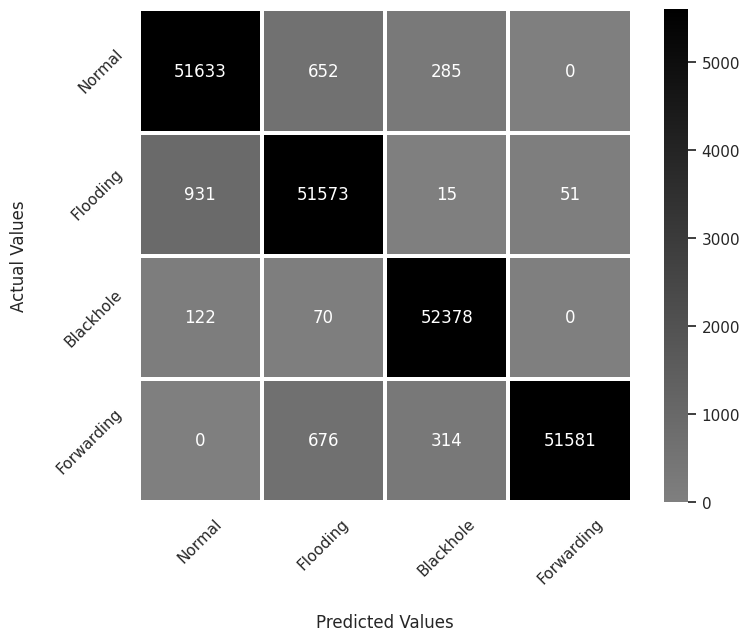

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

Confusion Matrix of MLP-LSTM Model


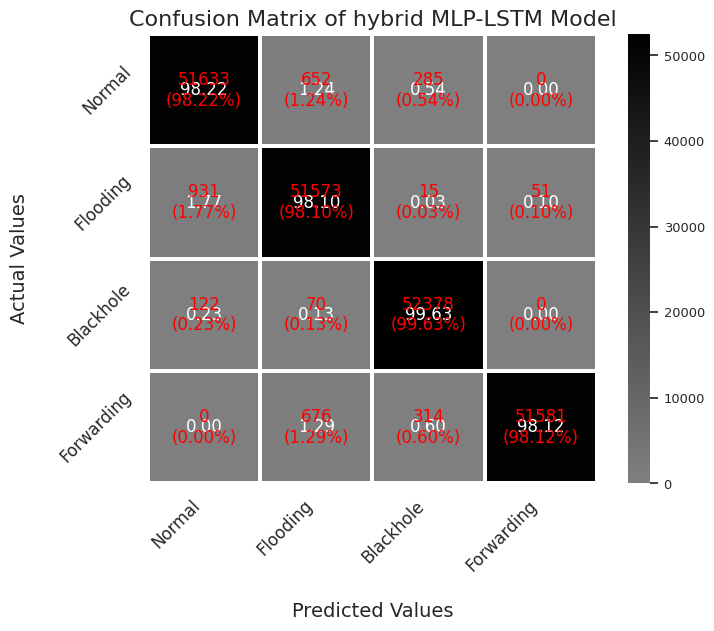

In [ ]:
# prompt: Plot the Confusion Matrix of Federated DL// MLP-LSTM Model in the way more mathmatically

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6.5))

    # Annotate with percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    ax = sns.heatmap(cm, annot=cm_percent, fmt=".2f", cmap="gist_yarg",  # Use a suitable colormap
                     vmin=0, vmax=52500, center=0, square=True, linewidths=1.5, annot_kws={"fontsize":12}) # Customize font size
    sns.set(font_scale=1.2) # Adjust font scale for better readability
    ax.set_xlabel('\nPredicted Values', fontsize=14)
    ax.set_ylabel('Actual Values\n', fontsize=14)
    ax.xaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'], fontsize=12)
    ax.yaxis.set_ticklabels(['Normal','Flooding','Blackhole','Forwarding'], fontsize=12)
    plt.xticks(rotation=45, ha='right') # Align x-axis labels
    plt.yticks(rotation=45) # Ensure y-axis labels are horizontal
    plt.title('Confusion Matrix of hybrid MLP-LSTM Model', fontsize=16) # Add title


    # Add text annotations for actual counts within each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}\n({cm_percent[i,j]:.2f}%)',
                     ha='center', va='center', color='red', fontsize=12)  # Customize fontsize for annotations



    plt.tight_layout()
    plt.show()

print("Confusion Matrix of MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

**Federated Learning Simulation (FedAvg)**

In [ ]:
# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    # Split training data among clients
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    # Initialize the global model
    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the global model
    global_weights = global_model.get_weights()

    for round in range(25):  # Simulate 10 communication rounds
        local_weights = []

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the local model

            # Train the local model
            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"Round {round + 1}: Global Model Accuracy = {acc:.10f}")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Round 1: Global Model Accuracy = 0.5569404960
Round 2: Global Model Accuracy = 0.8725039363
Round 3: Global Model Accuracy = 0.9022307992
Round 4: Global Model Accuracy = 0.9073240161
Round 5: Global Model Accuracy = 0.9192746878
Round 6: Global Model Accuracy = 0.9139104486
Round 7: Global Model Accuracy = 0.9270595312
Round 8: Global Model Accuracy = 0.9405509830
Round 9: Global Model Accuracy = 0.9334176779
Round 10: Global Model Accuracy = 0.9366751909
Round 11: Global Model Accuracy = 0.9395237565
Round 12: Global Model Accuracy = 0.9424151778
Round 13: Global Model Accuracy = 0.9419729114
Round 14: Global Model Accuracy = 0.9491584897
Round 15: Global Model Accuracy = 0.9468473196
Round 16: Global Model Accuracy = 0.9564440250
Round 17: Global Model Accuracy = 0.9576756954
Round 18: Global Model Accuracy = 0.9561158419
Round 19: Global Model Accuracy = 0.9531912208
Round 20: Global Model Accuracy = 0.9570812583
Round 21: Global Model Accuracy = 0.9548223615
Round 22: Global Model

In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.2f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(50):  # Simulate 50 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.2f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.2f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 1: Global Model Accuracy = 0.5627707839
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.5627707686
Precision: 0.5351710914
Recall: 0.5627707686
F1-Score: 0.5191595749

Confusion Matrix:
[[39186  4400  8734   250]
 [35340  5388  6063  5779]
 [18108  7776 21530  5156]
 [    0     0   335 52236]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 2: Global Model Accuracy = 0.8608290553
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.8608290811
Precision: 0.8623147455
Recall: 0.8608290811
F1-Score: 0.8572356988

Confusion Matrix:
[[36262 11485  4822     1]
 [ 4133 42836   213  5388]
 [  263   292 50015  2000]
 [    0     0   668 51903]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 3: Global Model Accuracy = 0.9003143311
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9003143413
Precision: 0.9083315975
Recall: 0.9003143413
F1-Score: 0.8981236769

Confusion Matrix:
[[38195 10980  3395     0]
 [  422 48463    92  3593]
 [  176   171 51036  1187]
 [    0   151   795 51625]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 4: Global Model Accuracy = 0.9094449878
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step

Model Performance Metrics:
Accuracy: 0.9094449808
Precision: 0.9169324754
Recall: 0.9094449808
F1-Score: 0.9079040392

Confusion Matrix:
[[39646 10006  2918     0]
 [  151 48907    63  3449]
 [   84    79 51551   856]
 [    0   436  1000 51135]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 5: Global Model Accuracy = 0.9189037681
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9189037526
Precision: 0.9245406169
Recall: 0.9189037526
F1-Score: 0.9175546332

Confusion Matrix:
[[40999  8316  3255     0]
 [  118 49155    59  3238]
 [   65    87 51776   642]
 [    0   191  1082 51298]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 6: Global Model Accuracy = 0.9174723625
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step

Model Performance Metrics:
Accuracy: 0.9174723346
Precision: 0.9235676325
Recall: 0.9174723346
F1-Score: 0.9163011010

Confusion Matrix:
[[41000  8861  2709     0]
 [   78 48716    56  3720]
 [   65    99 51659   747]
 [    0   451   568 51552]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 7: Global Model Accuracy = 0.9234738350
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9234738279
Precision: 0.9284319287
Recall: 0.9234738279
F1-Score: 0.9222683545

Confusion Matrix:
[[41683  7621  3266     0]
 [  105 49229    42  3194]
 [   71    88 52099   312]
 [    0   190  1203 51178]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 8: Global Model Accuracy = 0.9258611202
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9258611097
Precision: 0.9308259912
Recall: 0.9258611097
F1-Score: 0.9247953881

Confusion Matrix:
[[42000  7552  3017     1]
 [  102 49500    50  2918]
 [   82    83 52405     0]
 [    0   379  1406 50786]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 9: Global Model Accuracy = 0.9331418276
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step

Model Performance Metrics:
Accuracy: 0.9331418435
Precision: 0.9371309461
Recall: 0.9331418435
F1-Score: 0.9323611008

Confusion Matrix:
[[43228  6373  2969     0]
 [  199 50047    45  2279]
 [   84    83 52400     3]
 [    0   435  1589 50547]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 10: Global Model Accuracy = 0.9391908646
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step

Model Performance Metrics:
Accuracy: 0.9391908922
Precision: 0.9424569394
Recall: 0.9391908922
F1-Score: 0.9386000480

Confusion Matrix:
[[44102  6000  2468     0]
 [  209 50119    36  2206]
 [   75    74 52411    10]
 [    0   583  1126 50862]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 11: Global Model Accuracy = 0.9411882162
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9411882196
Precision: 0.9434730023
Recall: 0.9411882196
F1-Score: 0.9406901150

Confusion Matrix:
[[44932  5367  2271     0]
 [  356 49615    30  2569]
 [   98    67 52327    78]
 [    0   345  1186 51040]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 12: Global Model Accuracy = 0.9525492191
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9525492080
Precision: 0.9550896624
Recall: 0.9525492080
F1-Score: 0.9523018470

Confusion Matrix:
[[45974  4725  1871     0]
 [  364 51430    29   747]
 [   85    69 52406    10]
 [    0   863  1215 50493]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 13: Global Model Accuracy = 0.9519642591
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step

Model Performance Metrics:
Accuracy: 0.9519642764
Precision: 0.9550131367
Recall: 0.9519642764
F1-Score: 0.9517324953

Confusion Matrix:
[[45556  5366  1648     0]
 [  313 51514    31   712]
 [   84    80 52403     3]
 [    0  1045   819 50707]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 14: Global Model Accuracy = 0.9567435980
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9567435955
Precision: 0.9589461839
Recall: 0.9567435955
F1-Score: 0.9565907964

Confusion Matrix:
[[46508  4572  1490     0]
 [  394 51455    26   695]
 [  100    59 52411     0]
 [    0  1027   733 50811]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 15: Global Model Accuracy = 0.9553406835
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9553407108
Precision: 0.9582385331
Recall: 0.9553407108
F1-Score: 0.9552261873

Confusion Matrix:
[[46506  4284  1780     0]
 [  458 52018    28    66]
 [  103    59 52408     0]
 [    0  1480  1133 49958]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 16: Global Model Accuracy = 0.9581464529
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9581464802
Precision: 0.9602841187
Recall: 0.9581464802
F1-Score: 0.9580460237

Confusion Matrix:
[[47010  4016  1544     0]
 [  492 51749    26   303]
 [  124    63 52379     4]
 [    0  1181  1048 50342]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 17: Global Model Accuracy = 0.9562252164
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9562252415
Precision: 0.9592664711
Recall: 0.9562252415
F1-Score: 0.9561522752

Confusion Matrix:
[[46573  4446  1551     0]
 [  391 52114    23    42]
 [  101    72 52397     0]
 [    0  1539  1040 49992]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 18: Global Model Accuracy = 0.9594162107
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9594162097
Precision: 0.9619554085
Recall: 0.9594162097
F1-Score: 0.9593760934

Confusion Matrix:
[[47042  4077  1451     0]
 [  395 52078    27    70]
 [  113    69 52343    45]
 [    0  1538   749 50284]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 19: Global Model Accuracy = 0.9606621861
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9606621616
Precision: 0.9627103837
Recall: 0.9606621616
F1-Score: 0.9606336031

Confusion Matrix:
[[47501  3712  1357     0]
 [  493 51853    24   200]
 [  122    66 52382     0]
 [    0  1444   854 50273]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 20: Global Model Accuracy = 0.9598774910
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9598774973
Precision: 0.9623301233
Recall: 0.9598774973
F1-Score: 0.9598498700

Confusion Matrix:
[[47272  3848  1450     0]
 [  433 52067    29    41]
 [  110    64 52396     0]
 [    0  1595   867 50109]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 21: Global Model Accuracy = 0.9618653059
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9618653136
Precision: 0.9638743848
Recall: 0.9618653136
F1-Score: 0.9618373200

Confusion Matrix:
[[47611  3529  1430     0]
 [  529 51973    25    43]
 [  128    55 52387     0]
 [    0  1490   790 50291]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 22: Global Model Accuracy = 0.9616323113
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9616322920
Precision: 0.9638305475
Recall: 0.9616322920
F1-Score: 0.9615998974

Confusion Matrix:
[[47407  3834  1329     0]
 [  449 52047    28    46]
 [  117    61 52392     0]
 [    0  1392   812 50367]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 23: Global Model Accuracy = 0.9618843198
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9618843357
Precision: 0.9639466685
Recall: 0.9618843357
F1-Score: 0.9618225226

Confusion Matrix:
[[47473  3704  1393     0]
 [  439 52057    26    48]
 [  112    66 52392     0]
 [    0  1177  1050 50344]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 24: Global Model Accuracy = 0.9489111900
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9489112188
Precision: 0.9500695409
Recall: 0.9489112188
F1-Score: 0.9489045287

Confusion Matrix:
[[47359  3828  1383     0]
 [ 1800 49838    28   904]
 [   99    57 52414     0]
 [    0  1971   673 49927]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 25: Global Model Accuracy = 0.9637009501
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9637009525
Precision: 0.9656367907
Recall: 0.9637009525
F1-Score: 0.9636482096

Confusion Matrix:
[[47617  3605  1347     1]
 [  411 52090    27    42]
 [  103    67 52400     0]
 [    0  1180   850 50541]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 26: Global Model Accuracy = 0.9625976682
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9625976669
Precision: 0.9643780030
Recall: 0.9625976669
F1-Score: 0.9625774949

Confusion Matrix:
[[48004  3192  1374     0]
 [  594 51913    22    41]
 [  121    54 52395     0]
 [    0  1439  1028 50104]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 27: Global Model Accuracy = 0.9651513696
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9651513927
Precision: 0.9669040240
Recall: 0.9651513927
F1-Score: 0.9651328494

Confusion Matrix:
[[47877  3604  1089     0]
 [  478 52022    23    47]
 [  115    63 52392     0]
 [    0  1153   756 50662]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 28: Global Model Accuracy = 0.9592307210
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step

Model Performance Metrics:
Accuracy: 0.9592307436
Precision: 0.9611772726
Recall: 0.9592307436
F1-Score: 0.9592026140

Confusion Matrix:
[[47681  3421  1468     0]
 [  516 51675    21   358]
 [  107    68 52395     0]
 [    0  1575  1039 49957]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 29: Global Model Accuracy = 0.9623789191
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9623789120
Precision: 0.9647857789
Recall: 0.9623789120
F1-Score: 0.9623561683

Confusion Matrix:
[[47282  4234  1054     0]
 [  312 52190    26    42]
 [  125    54 52391     0]
 [    0  1228   836 50507]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 30: Global Model Accuracy = 0.9708200097
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9708199980
Precision: 0.9718289601
Recall: 0.9708199980
F1-Score: 0.9708157478

Confusion Matrix:
[[48810  2685  1075     0]
 [  595 51918    16    41]
 [  138    48 52383     1]
 [    0  1121   416 51034]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 31: Global Model Accuracy = 0.9607239962
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9607239836
Precision: 0.9629853288
Recall: 0.9607239836
F1-Score: 0.9607288036

Confusion Matrix:
[[47839  3366  1365     0]
 [  457 52048    24    41]
 [  116    47 52407     0]
 [    0  1792  1051 49728]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 32: Global Model Accuracy = 0.9665114880
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9665114775
Precision: 0.9682618092
Recall: 0.9665114775
F1-Score: 0.9664796842

Confusion Matrix:
[[47868  3673  1029     0]
 [  372 52130    24    44]
 [  107    50 52413     0]
 [    0  1014   729 50828]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 33: Global Model Accuracy = 0.9681093097
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9681093394
Precision: 0.9693523177
Recall: 0.9681093394
F1-Score: 0.9681372739

Confusion Matrix:
[[48962  2545  1063     0]
 [  628 51882    21    39]
 [  129    43 52398     0]
 [    0  1540   698 50333]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 34: Global Model Accuracy = 0.9692649245
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9692649360
Precision: 0.9704347963
Recall: 0.9692649360
F1-Score: 0.9692176058

Confusion Matrix:
[[48475  2859  1236     0]
 [  522 51975    29    44]
 [   73    35 52462     0]
 [    0   912   753 50906]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 35: Global Model Accuracy = 0.9700734019
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9700733780
Precision: 0.9712084467
Recall: 0.9700733780
F1-Score: 0.9700634527

Confusion Matrix:
[[48726  2880   964     0]
 [  532 51970    23    45]
 [  103    37 52430     0]
 [    0  1003   706 50862]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 36: Global Model Accuracy = 0.9661738276
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9661738341
Precision: 0.9676740685
Recall: 0.9661738341
F1-Score: 0.9661687809

Confusion Matrix:
[[48528  2833  1209     0]
 [  545 51962    20    43]
 [   67    52 52451     0]
 [    0  1372   972 50227]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 37: Global Model Accuracy = 0.9682853222
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9682852944
Precision: 0.9696091894
Recall: 0.9682852944
F1-Score: 0.9682551444

Confusion Matrix:
[[48515  2828  1227     0]
 [  479 52016    29    46]
 [   67    33 52470     0]
 [    0  1099   861 50611]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 38: Global Model Accuracy = 0.9726271033
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9726271037
Precision: 0.9734652461
Recall: 0.9726271037
F1-Score: 0.9726075081

Confusion Matrix:
[[49055  2466  1049     0]
 [  577 51933    19    41]
 [   96    44 52430     0]
 [    0   899   565 51107]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 39: Global Model Accuracy = 0.9688084126
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9688084040
Precision: 0.9703221367
Recall: 0.9688084040
F1-Score: 0.9688703836

Confusion Matrix:
[[48927  2940   703     0]
 [  436 52066    19    49]
 [  102    39 52429     0]
 [    0  1521   750 50300]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 40: Global Model Accuracy = 0.9728316069
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9728315920
Precision: 0.9734884066
Recall: 0.9728315920
F1-Score: 0.9728203670

Confusion Matrix:
[[49397  2117  1056     0]
 [  748 51760    16    46]
 [  106    34 52430     0]
 [    0   942   648 50981]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 41: Global Model Accuracy = 0.9719042778
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9719042614
Precision: 0.9729265173
Recall: 0.9719042614
F1-Score: 0.9718998026

Confusion Matrix:
[[48948  2684   938     0]
 [  498 52005    21    46]
 [   87    38 52442     3]
 [    0  1008   585 50978]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 42: Global Model Accuracy = 0.9715713859
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9715713735
Precision: 0.9724799714
Recall: 0.9715713735
F1-Score: 0.9715405116

Confusion Matrix:
[[49029  2270  1271     0]
 [  559 51950    18    43]
 [   69    31 52470     0]
 [    0   969   748 50854]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 43: Global Model Accuracy = 0.9725795388
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9725795483
Precision: 0.9734147472
Recall: 0.9725795483
F1-Score: 0.9725956666

Confusion Matrix:
[[49429  2325   816     0]
 [  630 51881    18    41]
 [  116    28 52426     0]
 [    0  1119   673 50779]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 44: Global Model Accuracy = 0.9588978291
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9588978557
Precision: 0.9591659109
Recall: 0.9588978557
F1-Score: 0.9588503258

Confusion Matrix:
[[48749  2818  1003     0]
 [ 1861 49781    16   912]
 [  117    25 52428     0]
 [    0  1247   644 50680]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 45: Global Model Accuracy = 0.9759845138
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9759845160
Precision: 0.9764475440
Recall: 0.9759845160
F1-Score: 0.9759910040

Confusion Matrix:
[[50048  1680   842     0]
 [  746 51763    17    44]
 [  125    32 52413     0]
 [    0   957   607 51007]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 46: Global Model Accuracy = 0.9753900766
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9753900733
Precision: 0.9760482621
Recall: 0.9753900733
F1-Score: 0.9753936167

Confusion Matrix:
[[49570  2193   807     0]
 [  559 51950    13    48]
 [  119    32 52417     2]
 [    0   903   499 51169]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 47: Global Model Accuracy = 0.9744151831
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9744151873
Precision: 0.9749591242
Recall: 0.9744151873
F1-Score: 0.9743983171

Confusion Matrix:
[[49547  1974  1049     0]
 [  761 51752    14    43]
 [   85    25 52460     0]
 [    0   837   592 51142]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 48: Global Model Accuracy = 0.9779913425
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9779913544
Precision: 0.9784226893
Recall: 0.9779913544
F1-Score: 0.9779686140

Confusion Matrix:
[[49686  2051   833     0]
 [  619 51887    19    45]
 [   73    28 52469     0]
 [    0   563   397 51611]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 49: Global Model Accuracy = 0.9411454201
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step

Model Performance Metrics:
Accuracy: 0.9411454197
Precision: 0.9417581717
Recall: 0.9411454197
F1-Score: 0.9408709437

Confusion Matrix:
[[49320  2395   855     0]
 [ 6428 45215    15   912]
 [  106    29 52435     0]
 [    0  1076   560 50935]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.77 MB

Round 50: Global Model Accuracy = 0.9771686196
6572/6572 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

Model Performance Metrics:
Accuracy: 0.9771686458
Precision: 0.9776591666
Recall: 0.9771686458
F1-Score: 0.9771773149

Confusion Matrix:
[[50122  1762   686     0]
 [  646 51859    19    46]
 [   71    22 52477     0]
 [    0   903   646 51022]]

Latency Analysis:
Average Latency per Round: 206.00 seconds
Total Latency for 10 Rounds: 10300.22 seconds
